In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import load_model

lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random




Using TensorFlow backend.
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rukesh/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:

words = []
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('all_data.json').read()
intents = json.loads(data_file)

for intent in intents['intents']:
    for pattern in intent['patterns']:

        # tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])



In [3]:
# lemmaztize and lower each word and remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print(len(documents), "documents")
# classes = intents
print(len(classes), "classes", classes)
# words = all words, vocabulary
print(len(words), "unique lemmatized words", words)

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))



199 documents
21 classes ['account', 'afternoon', 'changepasswordfrommobile', 'compensation', 'farfromrouter', 'fup', 'gamingwinprice', 'goodevening', 'goodmorning', 'greeting', 'hosting', 'nettv', 'nointernetconnection', 'offensive', 'onlinegaming', 'onlineservices', 'portforward', 'safenet', 'secondaryrouter', 'slowconnection', 'thankyou']
452 unique lemmatized words ['%', "''", ',', '.', '100', '11', '23', '5', '7', '8', '``', 'a', 'able', 'about', 'above', 'access', 'account', 'activate', 'ad', 'add', 'after', 'afternoon', 'all', 'also', 'alternative', 'am', 'amount', 'an', 'and', 'another', 'any', 'anyone', 'apologize', 'app/application', 'application', 'application/app', 'are', 'at', 'avoid', 'back', 'be', 'been', 'bhaster', 'bitch', 'black', 'block', 'boro', 'branch', 'bro', 'brother', 'browing', 'browsing', 'buddy', 'but', 'button', 'ca', 'cable', 'calling', 'came', 'can', "cant't", 'catch', 'certain', 'change', 'channel', 'check', 'claim', 'client', 'color', 'come', 'compensat

In [4]:

# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:, 0])
train_y = list(training[:, 1])
print("Training data created")



Training data created


In [5]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))




try:
#     model = load_model('chatbot_model.h5')
    print("model load successfully")
except:
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    # fitting and saving the model
    history = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
    model.save('chatbot_model.h5', history)

    print("model created")


model.summary()





Epoch 1/200
199/199 [==============================] - 0s 752us/step - loss: 3.0614 - accuracy: 0.0754
Epoch 2/200
199/199 [==============================] - 0s 171us/step - loss: 2.8755 - accuracy: 0.1658
Epoch 3/200
199/199 [==============================] - 0s 168us/step - loss: 2.7018 - accuracy: 0.1910
Epoch 4/200
199/199 [==============================] - 0s 172us/step - loss: 2.5889 - accuracy: 0.2563
Epoch 5/200
199/199 [==============================] - 0s 169us/step - loss: 2.3662 - accuracy: 0.2764
Epoch 6/200
199/199 [==============================] - 0s 164us/step - loss: 2.1901 - accuracy: 0.3719
Epoch 7/200
199/199 [==============================] - 0s 158us/step - loss: 2.0272 - accuracy: 0.3869
Epoch 8/200
199/199 [==============================] - 0s 155us/step - loss: 1.9119 - accuracy: 0.4221
Epoch 9/200
199/199 [==============================] - 0s 155us/step - loss: 1.7066 - accuracy: 0.4774
Epoch 10/200
199/199 [==============================] - 0s 151us/step - 

199/199 [==============================] - 0s 144us/step - loss: 0.1880 - accuracy: 0.9246
Epoch 78/200
199/199 [==============================] - 0s 151us/step - loss: 0.2117 - accuracy: 0.9347
Epoch 79/200
199/199 [==============================] - 0s 148us/step - loss: 0.1598 - accuracy: 0.9598
Epoch 80/200
199/199 [==============================] - 0s 143us/step - loss: 0.2052 - accuracy: 0.9648
Epoch 81/200
199/199 [==============================] - 0s 145us/step - loss: 0.1559 - accuracy: 0.9497
Epoch 82/200
199/199 [==============================] - 0s 142us/step - loss: 0.1590 - accuracy: 0.9648
Epoch 83/200
199/199 [==============================] - 0s 146us/step - loss: 0.0993 - accuracy: 0.9749
Epoch 84/200
199/199 [==============================] - 0s 145us/step - loss: 0.1729 - accuracy: 0.9548
Epoch 85/200
199/199 [==============================] - 0s 144us/step - loss: 0.1902 - accuracy: 0.9447
Epoch 86/200
199/199 [==============================] - 0s 144us/step - loss:

199/199 [==============================] - 0s 155us/step - loss: 0.1072 - accuracy: 0.9698
Epoch 156/200
199/199 [==============================] - 0s 144us/step - loss: 0.0488 - accuracy: 0.9799
Epoch 157/200
199/199 [==============================] - 0s 150us/step - loss: 0.0922 - accuracy: 0.9698
Epoch 158/200
199/199 [==============================] - 0s 145us/step - loss: 0.0952 - accuracy: 0.9749
Epoch 159/200
199/199 [==============================] - 0s 150us/step - loss: 0.0734 - accuracy: 0.9849
Epoch 160/200
199/199 [==============================] - 0s 153us/step - loss: 0.0891 - accuracy: 0.9749
Epoch 161/200
199/199 [==============================] - 0s 150us/step - loss: 0.0880 - accuracy: 0.9598
Epoch 162/200
199/199 [==============================] - 0s 152us/step - loss: 0.1284 - accuracy: 0.9598
Epoch 163/200
199/199 [==============================] - 0s 152us/step - loss: 0.0818 - accuracy: 0.9698
Epoch 164/200
199/199 [==============================] - 0s 147us/ste

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


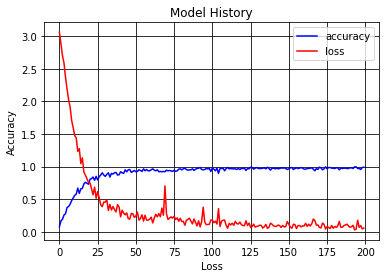

In [8]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['loss'],color='red',label='loss')

plt.title('Model History')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.grid(True,color='k')
plt.legend(['accuracy', 'loss'])
plt.show()